/tmp/ipykernel_30/1949593283.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['emotion_label'] = le.fit_transform(filtered_data['emotion'])


Total number of labeled files across Session 1 and 2: 2779


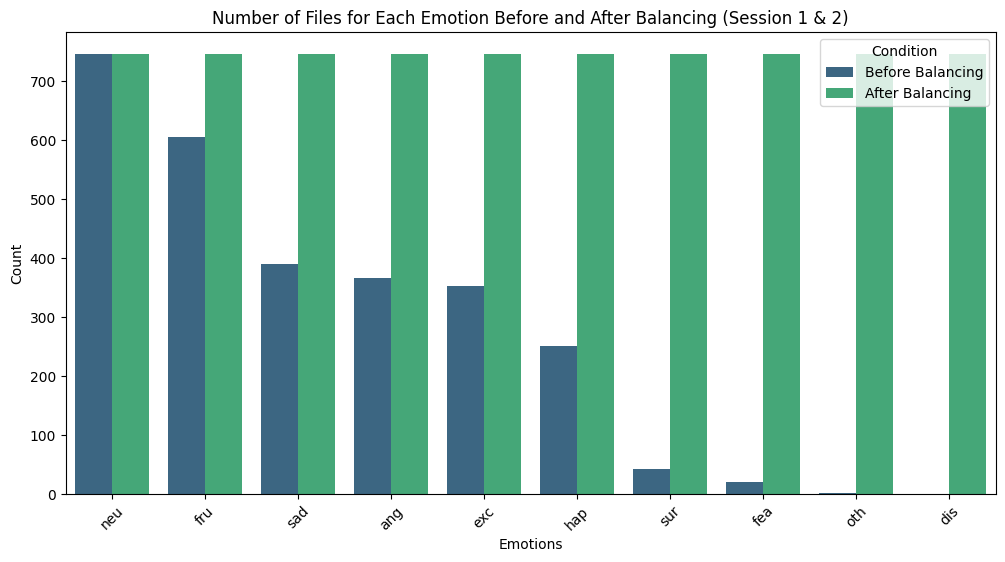

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

# Define base directories for Sessions 1 and 2
session1_directory = '/kaggle/input/iemocapfullrelease/IEMOCAP_full_release/Session1/sentences/wav/'  # Adjust if necessary
session2_directory = '/kaggle/input/iemocapfullrelease/IEMOCAP_full_release/Session2/sentences/wav/'  # Adjust as needed
csv_file_path = '/kaggle/input/iemocap-csv/iemocap_full_dataset.csv'  # Adjust to match the uploaded CSV file path

# Load the CSV file
data = pd.read_csv(csv_file_path)

# Update the paths in the 'path' column to match Kaggle's file structure for both sessions
data['path'] = data['path'].apply(lambda x: x.replace('Session1/sentences/wav/', session1_directory))
data['path'] = data['path'].apply(lambda x: x.replace('Session2/sentences/wav/', session2_directory))

# Filter data for valid emotions (not 'xxx') and files from Session 1 or Session 2
filtered_data = data[(data['emotion'] != 'xxx') & 
                     (data['path'].str.contains(session1_directory) | data['path'].str.contains(session2_directory))]

# Encode emotion labels
le = LabelEncoder()
filtered_data['emotion_label'] = le.fit_transform(filtered_data['emotion'])

# Display the total number of labeled files
total_labeled_files = filtered_data.shape[0]
print(f"Total number of labeled files across Session 1 and 2: {total_labeled_files}")

# Count the number of files for each emotion
emotion_counts = filtered_data['emotion'].value_counts()

# Balance the dataset
balanced_data = pd.DataFrame()  # Initialize an empty DataFrame for balanced data
max_count = emotion_counts.max()  # Find the maximum count of any emotion category

# Resample each emotion to match the maximum count
for emotion in emotion_counts.index:
    subset = filtered_data[filtered_data['emotion'] == emotion]
    if len(subset) < max_count:
        # Upsample to match the majority class count
        subset = resample(subset, replace=True, n_samples=max_count, random_state=42)
    balanced_data = pd.concat([balanced_data, subset])

# Verify balancing by counting the files per emotion in the balanced dataset
balanced_emotion_counts = balanced_data['emotion'].value_counts()

# Prepare data for side-by-side bar plot
emotion_data = pd.DataFrame({
    'Emotion': emotion_counts.index,
    'Before Balancing': emotion_counts.values,
    'After Balancing': balanced_emotion_counts[emotion_counts.index].values  # Ensure order matches 'Before Balancing'
})

# Melt the DataFrame for seaborn compatibility
emotion_data_melted = emotion_data.melt(id_vars='Emotion', 
                                        value_vars=['Before Balancing', 'After Balancing'], 
                                        var_name='Condition', 
                                        value_name='Count')

# Plot side-by-side bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=emotion_data_melted, x='Emotion', y='Count', hue='Condition', palette='viridis')
plt.title('Number of Files for Each Emotion Before and After Balancing (Session 1 & 2)')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Condition')
plt.show()


In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, Reshape

# Define the model function
def create_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    # BiLSTM branch
    bilstm_input = Reshape((13, 1))(input_layer)
    bilstm1 = Bidirectional(LSTM(64, return_sequences=True))(bilstm_input)
    bilstm2 = Bidirectional(LSTM(64))(bilstm1)

    # Conv2D branch
    conv_input = Reshape((13, 1, 1))(input_layer)
    conv2d = Conv2D(32, kernel_size=(3, 1), dilation_rate=(2, 1), activation='relu', padding='same')(conv_input)
    conv2d = BatchNormalization()(conv2d)
    conv2d = MaxPooling2D(pool_size=(2, 1))(conv2d)

    conv2d = Conv2D(64, kernel_size=(3, 1), dilation_rate=(2, 1), activation='relu', padding='same')(conv2d)
    conv2d = BatchNormalization()(conv2d)
    conv2d = MaxPooling2D(pool_size=(2, 1))(conv2d)

    conv2d = Conv2D(128, kernel_size=(3, 1), dilation_rate=(2, 1), activation='relu', padding='same')(conv2d)
    conv2d = BatchNormalization()(conv2d)
    conv2d = MaxPooling2D(pool_size=(2, 1))(conv2d)

    # Flatten and dense layers for Conv2D branch
    conv_flat = Flatten()(conv2d)
    dense1 = Dense(512, activation='relu')(conv_flat)
    dropout4 = Dropout(0.2)(dense1)
    dense2 = Dense(128, activation='relu')(dropout4)
    dropout5 = Dropout(0.2)(dense2)

    # Concatenate BiLSTM and Conv2D branches
    concatenated = Concatenate()([bilstm2, dropout5])
    dense = Dense(64, activation='relu')(concatenated)
    output_layer = Dense(num_classes, activation='softmax')(dense)

    # Model definition and compilation
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
model = create_model((13, 1), 10)  # Adjust the number of classes as needed

# Print the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 13, 1, 1)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 13, 1, 32) │        128 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 13, 1, 32) │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 6, 1, 32)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 6, 1, 64)  │      6,208 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 1, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 3, 1, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 3, 1, 128) │     24,704 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 1, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 1, 1, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │     66,048 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 13, 1)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 13, 128)   │     33,792 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     65,664 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     98,816 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ bidirectional_1[… │
│ (Concatenate)       │                   │            │ dropout_1[0][0] 

 Total params: 313,354 (1.20 MB)

 Trainable params: 312,906 (1.19 MB)

 Non-trainable params: 448 (1.75 KB)

In [4]:
import numpy as np
import librosa
import pickle

# Function to extract MFCC features using librosa
def extract_mfcc(file_path, n_mfcc=13):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)  # Load audio with its original sample rate
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        return np.mean(mfccs.T, axis=0)  # Return the mean of the MFCCs over time
    except Exception as e:
        print(f"Error extracting MFCC for {file_path}: {e}")
        return None

# Lists to store features and labels
X_balanced = []
y_balanced = []

# Extract MFCC features from each file in the balanced dataset
for index, row in balanced_data.iterrows():
    file_path = row['path']
    mfcc_features = extract_mfcc(file_path)
    if mfcc_features is not None:  # Only add if extraction was successful
        X_balanced.append(mfcc_features)
        y_balanced.append(row['emotion_label'])

# Convert lists to arrays (split them here)
X_balanced = np.array(X_balanced)
y_balanced = np.array(y_balanced)

# Now you have X_balanced and y_balanced as separate variables
print("MFCC features and labels are now separated.")


MFCC features and labels are now separated.


In [5]:
# Print the shapes of the feature and label arrays
print(f"Shape of X_balanced (features): {X_balanced.shape}")
print(f"Shape of y_balanced (labels): {y_balanced.shape}")


Shape of X_balanced (features): (7460, 13)
Shape of y_balanced (labels): (7460,)


In [4]:
import numpy as np
import librosa
import pickle

# Function to extract MFCC features using librosa
def extract_mfcc(file_path, n_mfcc=13):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)  # Load audio with its original sample rate
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        return mfccs  # Return the MFCCs as a 2D array (n_mfcc x time_frames)
    except Exception as e:
        print(f"Error extracting MFCC for {file_path}: {e}")
        return None

# Function to augment audio with time stretch and pitch shift
def augment_audio(audio, sample_rate):
    # Time Stretching
    stretch_rate = np.random.uniform(0.8, 1.2)  # Stretch factor between 0.8 and 1.2
    audio_stretched = librosa.effects.time_stretch(audio.astype(float), rate=stretch_rate)
    
    # Pitch Shifting
    n_steps = np.random.randint(-2, 3)  # Random pitch shift between -2 and +2 semitones
    audio_pitched = librosa.effects.pitch_shift(audio_stretched, sr=sample_rate, n_steps=n_steps)
    
    return audio_pitched

# Lists to store features and labels for augmented data
X_augmented = []
y_augmented = []

# Apply augmentation (time stretch and pitch shift) to each sample in the balanced dataset
for index, row in balanced_data.iterrows():
    file_path = row['path']
    mfcc_features = extract_mfcc(file_path)
    
    if mfcc_features is not None:
        # Convert the MFCCs back to audio
        audio, sample_rate = librosa.load(file_path, sr=None)
        
        # Apply augmentation
        augmented_audio = augment_audio(audio, sample_rate)
        
        # Re-extract MFCC from augmented audio
        augmented_mfcc = librosa.feature.mfcc(y=augmented_audio, sr=sample_rate, n_mfcc=13)
        
        # Store the augmented data (mean over time for simplicity)
        X_augmented.append(np.mean(augmented_mfcc.T, axis=0))
        y_augmented.append(row['emotion_label'])

# Convert lists to arrays
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Print the shape of the augmented data
print(f"Shape of X_augmented (features): {X_augmented.shape}")
print(f"Shape of y_augmented (labels): {y_augmented.shape}")

# Save the augmented features and labels as a pickle file
with open('augmented_mfcc_features.pkl', 'wb') as f:
    pickle.dump((X_augmented, y_augmented), f)

print("Augmented MFCC features and labels saved to 'augmented_mfcc_features.pkl'.")


Shape of X_augmented (features): (7460, 13)
Shape of y_augmented (labels): (7460,)
Augmented MFCC features and labels saved to 'augmented_mfcc_features.pkl'.


In [6]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, Reshape
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Assuming X_augmented and y_augmented are already defined and reshaped
X = X_augmented  # Features
y = y_augmented  # Labels

# One-hot encode the labels
lb = LabelBinarizer()
y_categorical = lb.fit_transform(y)

# Define the model function
def create_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    # BiLSTM branch
    bilstm_input = Reshape((13, 1))(input_layer)
    bilstm1 = Bidirectional(LSTM(64, return_sequences=True))(bilstm_input)
    bilstm2 = Bidirectional(LSTM(64))(bilstm1)

    # Conv2D branch
    conv_input = Reshape((13, 1, 1))(input_layer)
    conv2d = Conv2D(32, kernel_size=(3, 1), dilation_rate=(2, 1), activation='relu', padding='same')(conv_input)
    conv2d = BatchNormalization()(conv2d)
    conv2d = MaxPooling2D(pool_size=(2, 1))(conv2d)

    conv2d = Conv2D(64, kernel_size=(3, 1), dilation_rate=(2, 1), activation='relu', padding='same')(conv2d)
    conv2d = BatchNormalization()(conv2d)
    conv2d = MaxPooling2D(pool_size=(2, 1))(conv2d)

    conv2d = Conv2D(128, kernel_size=(3, 1), dilation_rate=(2, 1), activation='relu', padding='same')(conv2d)
    conv2d = BatchNormalization()(conv2d)
    conv2d = MaxPooling2D(pool_size=(2, 1))(conv2d)

    # Flatten and dense layers for Conv2D branch
    conv_flat = Flatten()(conv2d)
    dense1 = Dense(512, activation='relu')(conv_flat)
    dropout4 = Dropout(0.2)(dense1)
    dense2 = Dense(128, activation='relu')(dropout4)
    dropout5 = Dropout(0.2)(dense2)

    # Concatenate BiLSTM and Conv2D branches
    concatenated = Concatenate()([bilstm2, dropout5])
    dense = Dense(64, activation='relu')(concatenated)
    output_layer = Dense(num_classes, activation='softmax')(dense)

    # Model definition and compilation
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
fold_no = 1
fold_accuracies = []

for train_index, val_index in kf.split(X):
    print(f"\nTraining fold {fold_no}...")

    # Split data into train and validation for this fold
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_categorical[train_index], y_categorical[val_index]
    
    # Reshape the data as needed
    X_train = X_train.reshape((-1, 13, 1))
    X_val = X_val.reshape((-1, 13, 1))

    # Create the model
    model = create_model((13, 1), y_train.shape[1])

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=32,
        epochs=30,
        callbacks=[reduce_lr, early_stopping],
        verbose=1
    )

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation accuracy for fold {fold_no}: {val_accuracy}")
    fold_accuracies.append(val_accuracy)
    
    fold_no += 1

# Calculate the average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Cross-Validation Accuracy: {average_accuracy}")



Training fold 1...
Epoch 1/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.3372 - loss: 1.8217 - val_accuracy: 0.3264 - val_loss: 1.8430 - learning_rate: 0.0010
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4798 - loss: 1.4090 - val_accuracy: 0.4638 - val_loss: 1.4276 - learning_rate: 0.0010
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5126 - loss: 1.3405 - val_accuracy: 0.5422 - val_loss: 1.2624 - learning_rate: 0.0010
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5648 - loss: 1.2201 - val_accuracy: 0.5127 - val_loss: 1.3443 - learning_rate: 0.0010
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5768 - loss: 1.1698 - val_accuracy: 0.5536 - val_loss: 1.2168 - learning_rate: 0.0010
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5783 - loss: 1.1482 - val_accuracy: 0.5791 - val_loss: 1.1723 - learning_rate: 0.0010
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accura

# Emo-Net

In [6]:
import numpy as np
import librosa
import pickle

# Function to extract MFCC features using librosa
def extract_mfcc(file_path, n_mfcc=13):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)  # Load audio with its original sample rate
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        return mfccs  # Return the MFCCs as a 2D array (n_mfcc x time_frames)
    except Exception as e:
        print(f"Error extracting MFCC for {file_path}: {e}")
        return None

# Function to augment audio with time stretch and pitch shift
def augment_audio(audio, sample_rate):
    augmented_samples = []
    
    # Apply multiple augmentations
    for _ in range(3):  # Apply 3 augmentations per sample
        # Time Stretching
        stretch_rate = np.random.uniform(0.8, 1.2)  # Stretch factor between 0.8 and 1.2
        audio_stretched = librosa.effects.time_stretch(audio.astype(float), rate=stretch_rate)
        
        # Pitch Shifting
        n_steps = np.random.randint(-2, 3)  # Random pitch shift between -2 and +2 semitones
        audio_pitched = librosa.effects.pitch_shift(audio_stretched, sr=sample_rate, n_steps=n_steps)
        
        augmented_samples.append(audio_pitched)
    
    return augmented_samples

# Lists to store features and labels for augmented data
X_augmented = []
y_augmented = []

# Apply augmentation (time stretch and pitch shift) to each sample in the balanced dataset
for index, row in balanced_data.iterrows():
    file_path = row['path']
    mfcc_features = extract_mfcc(file_path)
    
    if mfcc_features is not None:
        # Convert the MFCCs back to audio
        audio, sample_rate = librosa.load(file_path, sr=None)
        
        # Apply augmentation (get 3 augmented samples per original audio)
        augmented_audios = augment_audio(audio, sample_rate)
        
        # For each augmented audio, extract MFCC and append
        for augmented_audio in augmented_audios:
            augmented_mfcc = librosa.feature.mfcc(y=augmented_audio, sr=sample_rate, n_mfcc=13)
            X_augmented.append(np.mean(augmented_mfcc.T, axis=0))  # Take mean over time for simplicity
            y_augmented.append(row['emotion_label'])

# Convert lists to arrays
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Print the shape of the augmented data
print(f"Shape of X_augmented (features): {X_augmented.shape}")
print(f"Shape of y_augmented (labels): {y_augmented.shape}")

# Save the augmented features and labels as a pickle file
with open('augmented_mfcc_features.pkl', 'wb') as f:
    pickle.dump((X_augmented, y_augmented), f)

print("Augmented MFCC features and labels saved to 'augmented_mfcc_features.pkl'.")


Shape of X_augmented (features): (22380, 13)
Shape of y_augmented (labels): (22380,)
Augmented MFCC features and labels saved to 'augmented_mfcc_features.pkl'.


In [10]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Reshape, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

# Assuming X_augmented and y_augmented are the augmented data features and labels

# One-hot encode the labels
lb = LabelBinarizer()
y_augmented_categorical = lb.fit_transform(y_augmented)

# Reshape the features as needed (13 MFCC coefficients per time frame)
X_augmented_reshaped = X_augmented.reshape((-1, 13, 1))

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
val_accuracies = []

# K-Fold Cross Validation
for train_index, val_index in kfold.split(X_augmented_reshaped, y_augmented_categorical):
    print(f"Training fold {fold_no}...")
    
    # Split data into training and validation sets
    X_train, X_val = X_augmented_reshaped[train_index], X_augmented_reshaped[val_index]
    y_train, y_val = y_augmented_categorical[train_index], y_augmented_categorical[val_index]
    
    # Define the model (BiLSTM + Conv2D with dilated convolutions)
    input_shape = (13, 1)
    input_layer = Input(shape=input_shape)
    
    # BiLSTM branch
    bilstm_input_model1 = Reshape((13, 1))(input_layer)
    bilstm1_model1 = Bidirectional(LSTM(64, return_sequences=True))(bilstm_input_model1)
    bilstm2_model1 = Bidirectional(LSTM(64))(bilstm1_model1)
    
    # Conv2D branch with Dilated Convolutions
    conv_input = Reshape((13, 1, 1))(input_layer)
    conv2d = Conv2D(32, kernel_size=(3, 1), dilation_rate=(2, 1), activation='relu', padding='same')(conv_input)
    conv2d = BatchNormalization()(conv2d)
    conv2d = MaxPooling2D(pool_size=(2, 1))(conv2d)
    
    conv2d = Conv2D(64, kernel_size=(3, 1), dilation_rate=(2, 1), activation='relu', padding='same')(conv2d)
    conv2d = BatchNormalization()(conv2d)
    conv2d = MaxPooling2D(pool_size=(2, 1))(conv2d)
    
    conv2d = Conv2D(128, kernel_size=(3, 1), dilation_rate=(2, 1), activation='relu', padding='same')(conv2d)
    conv2d = BatchNormalization()(conv2d)
    conv2d = MaxPooling2D(pool_size=(2, 1))(conv2d)
    
    # Flatten and dense layers for Conv2D branch
    conv_flat = Flatten()(conv2d)
    dense1 = Dense(512, activation='relu')(conv_flat)
    dropout4 = Dropout(0.2)(dense1)
    dense2 = Dense(128, activation='relu')(dropout4)
    dropout5 = Dropout(0.2)(dense2)
    
    # Concatenate BiLSTM and Conv2D branches
    concatenated = Concatenate()([bilstm2_model1, dropout5])
    dense = Dense(64, activation='relu')(concatenated)
    output_layer = Dense(y_train.shape[1], activation='softmax')(dense)
    
    # Model definition and compilation
    model_speech = Model(inputs=input_layer, outputs=output_layer)
    model_speech.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Callbacks for training
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model_speech.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=32,
        epochs=30,
        callbacks=[reduce_lr, early_stopping]
    )
    
    # Get the validation accuracy and store it
    val_accuracy = history.history['val_accuracy'][-1]
    val_accuracies.append(val_accuracy)
    
    # Print validation accuracy for the fold
    print(f"Validation accuracy for fold {fold_no}: {val_accuracy:.4f}")
    
    fold_no += 1

# Print the average validation accuracy across all folds
avg_val_accuracy = np.mean(val_accuracies)
print(f"\nAverage validation accuracy across all folds: {avg_val_accuracy:.4f}")


Training fold 1...
Epoch 1/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.3630 - loss: 1.7268 - val_accuracy: 0.5337 - val_loss: 1.3021 - learning_rate: 0.0010
Epoch 2/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5237 - loss: 1.2841 - val_accuracy: 0.5786 - val_loss: 1.1516 - learning_rate: 0.0010
Epoch 3/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5899 - loss: 1.1088 - val_accuracy: 0.6296 - val_loss: 1.0240 - learning_rate: 0.0010
Epoch 4/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6246 - loss: 1.0090 - val_accuracy: 0.6439 - val_loss: 0.9793 - learning_rate: 0.0010
Epoch 5/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.6525 - loss: 0.9304 - val_accuracy: 0.6591 - val_loss: 0.9126 - learning_rate: 0.0010
Epoch 6/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6859 - loss: 0.8373 - val_accuracy: 0.6859 - val_loss: 0.8547 - learning_rate: 0.0010
Epoch 7/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accurac